# Импорты

In [18]:
! pip install sentencepiece transformers sacrebleu HeapDict -q 

In [2]:
! wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
! protoc --python_out=. sentencepiece_model.proto

--2023-05-14 10:24:53--  https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13845 (14K) [text/plain]
Saving to: ‘sentencepiece_model.proto’

sentencepiece_model 100%[===================>]  13.52K  --.-KB/s    in 0s      

2023-05-14 10:24:53 (104 MB/s) - ‘sentencepiece_model.proto’ saved [13845/13845]



In [6]:
import torch
from transformers import MBartForConditionalGeneration, MBart50Tokenizer
import json
from collections import Counter, defaultdict
from tqdm.auto import tqdm, trange
import random
import re
from copy import deepcopy
import pandas as pd

# Добавляю в модель токены бурятского языка

In [5]:
tokenizer = MBart50Tokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

In [7]:
print(tokenizer.vocab_size)

250054


In [8]:
with open ('bur_all.txt', 'r', encoding='utf-8') as f:
   bur_all = f.readlines()

In [9]:
bur_all = set(bur_all)
len(bur_all)

203060

In [10]:
def get_tokens(text, tokenizer, verbose=False):
    toks = tokenizer.tokenize(text)
    words = []
    word = []
    prev_punct = False
    for tok in toks:
        is_punct = tok.lstrip(SPACE) and all(c in PUNCT for c in tok.lstrip(SPACE))
        if tok.startswith(SPACE) or prev_punct != is_punct:
            if word:
                words.append(word)
            word = []
        word.append(tok)
        prev_punct = is_punct
    if word:
        words.append(word)
    if verbose:
        print(words)
    res = words
    # assert tokenizer.decode([tok for t in res for tok in t]) == text
    return res

In [11]:
PUNCT = '.,-—:)(»«!?–/;„"“…*́№Ёҥ[]”^%+І=і•_􏰀²|}{#‘■>⁠’á<°\§\''
SPACE = '▁'
word_count = Counter()
word2toks = {}
for text in tqdm(bur_all):
    for word_toks in get_tokens(text, tokenizer):
        word = ''.join(word_toks)
        word_count[word] += 1
        word2toks[word] = word_toks
print(len(word_count))

  0%|          | 0/203060 [00:00<?, ?it/s]

465440


In [12]:
word_count2 = deepcopy(word_count)
word2toks2 = deepcopy(word2toks)

In [13]:
word_count = deepcopy(word_count2)
word2toks = deepcopy(word2toks2)

In [14]:
for k, v in word_count.most_common(30):
    if len(word2toks[k]) > 1:
        print(word2toks[k])

['▁гэж', 'э']
['▁h', 'эн']
['▁нэг', 'э']
['▁тэр', 'э']
['▁бай', 'h', 'ан']
['▁л', 'э']
['▁дээр', 'э']
['▁е', 'х', 'э']


In [15]:
steps = 100_000
min_count = 30  
# default:   0 new tokens, 30 lenght, 0% new tokens
# 100 mindf: 6.6k new tokens, 22 length, 47% new tokens (of sentence length)
# 30 mindf:  20k new tokens, 20 length, 58% new tokens
# 10 mindf: 50K new tokens, 18.5 length, 64% new tokens
extra_vocab = []
extra_counts = []
extra_pairs = []

In [16]:
pairs_count = Counter()
pair2word = defaultdict(set)
for w, c in tqdm(word_count.items(), total=len(word_count)):
    enc = word2toks[w]
    for pair in zip(enc[:-1], enc[1:]):
        pairs_count[pair] += c
        pair2word[pair].add(w)

  0%|          | 0/465440 [00:00<?, ?it/s]

In [19]:
from heapdict import heapdict
hd = heapdict()
for w, c in pairs_count.items():
    hd[w] = -c

In [20]:
def replace_pair(old_tokens, pair, new_token):
    result = []
    prev = old_tokens[0]
    for tok in old_tokens[1:]:
        if (prev, tok) == pair:
            result.append(new_token)
            prev = None
        else:
            if prev is not None:
                result.append(prev)
            prev = tok
    if prev is not None:
        result.append(prev)
    return result

In [21]:
for _ in trange(steps):
    #pair, c = pairs_count.most_common(1)[0]  # это самая времязатратная операция
    pair, c = hd.peekitem()
    c = -c
    
    if c < min_count:
        break
    new_token = ''.join(pair) # instead of BERT-like pair[0] + pair[1][2:]
    extra_vocab.append(pair)
    extra_counts.append(c)
    extra_pairs.append(pair)
    
    # update the vocabulary
    #new_id = len(id2ids)
    #tok2id[new_token] = new_id
    #id2ids.append(id2ids[tok2id[pair[0]]] + id2ids[tok2id[pair[1]]]) 
    
    # calculate the delta for the heap
    delta = Counter()
    for word in list(pair2word[pair]):
        # calculate old and new ways to tokenize the word
        old_toks = word2toks[word]
        # new_toks = " ".join(old_toks).replace(' '.join(pair), new_token).split(" ")
        new_toks = replace_pair(old_toks, pair, new_token)
        word2toks[word] = new_toks
        wc = word_count[word]
        # update the index concerning the tokens of the word
        for old_pair in zip(old_toks[:-1], old_toks[1:]):
            #pairs_count[old_pair] -= wc
            delta[old_pair] -= wc
            if word in pair2word[old_pair]:
                pair2word[old_pair].remove(word)
        for new_pair in zip(new_toks[:-1], new_toks[1:]):
            # pairs_count[new_pair] += wc
            delta[new_pair] += wc
            pair2word[new_pair].add(word)
    # update the heap
    for a_pair, a_delta in delta.items():
        if a_delta == 0:
            continue
        if a_pair not in hd:
            hd[a_pair] = 0
        hd[a_pair] -= a_delta

  0%|          | 0/100000 [00:00<?, ?it/s]

In [22]:
len(extra_pairs)

21813

In [23]:
extra_pairs[:10]

[('h', 'ан'),
 ('▁гэж', 'э'),
 ('h', 'эн'),
 ('х', 'э'),
 ('h', 'а'),
 ('б', 'э'),
 ('шь', 'е'),
 ('▁я', 'ба'),
 ('я', 'а'),
 ('h', 'аа')]

In [24]:
tokenizer.save_pretrained('old_tokenizer')

('old_tokenizer/tokenizer_config.json',
 'old_tokenizer/special_tokens_map.json',
 'old_tokenizer/sentencepiece.bpe.model',
 'old_tokenizer/added_tokens.json')

In [ ]:
# with open('extra_pairs.json', 'w', encoding='utf-8') as f:
#   json.dump(extra_pairs, f)

In [ ]:
# with open('extra_vocab.json', 'w', encoding='utf-8') as f:
#   json.dump(extra_vocab, f)

In [ ]:
# with open('extra_vocab.json', 'r', encoding='utf-8') as f:
#   extra_vocab = json.load(f)

In [ ]:
# with open('extra_pairs.json', 'r', encoding='utf-8') as f:
#   extra_pairs = json.load(f)

In [25]:
!pip install --upgrade "protobuf<=3.20.1"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.11.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cloud-bigquery 3.9.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cloud-bigquery-storage 2.19.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4

In [26]:
import sentencepiece_model_pb2 as model
m = model.ModelProto()
m.ParseFromString(open("old_tokenizer/sentencepiece.bpe.model", "rb").read())

5069051

In [27]:
scores = [p.score for p in m.pieces]
min_score = min(scores)
epsilon = 1e-4

In [28]:
for i, pair in enumerate(extra_vocab):
    new_token = model.ModelProto().SentencePiece()
    new_token.piece = ''.join(pair)
    new_token.score = min_score - epsilon * (i+1)
    m.pieces.append(new_token)

In [29]:
with open("old_tokenizer/sentencepiece.bpe.model", 'wb') as f:
    f.write(m.SerializeToString())

In [30]:
tokenizer =  MBart50Tokenizer.from_pretrained(
    "old_tokenizer/") 

In [31]:
new_tokenizer = MBart50Tokenizer.from_pretrained(
    "old_tokenizer/", 
    additional_special_tokens = tokenizer.additional_special_tokens
)

In [32]:
new_tokenizer.vocab_size

271867

7893 новых токенов

In [33]:
from transformers.models.mbart50.tokenization_mbart50 import FAIRSEQ_LANGUAGE_CODES

In [34]:
self = new_tokenizer

In [35]:
self.lang_code_to_id = {
    code: self.sp_model_size + i + self.fairseq_offset for i, code in enumerate(FAIRSEQ_LANGUAGE_CODES + ['bxr_XX'])
}
self.id_to_lang_code = {v: k for k, v in self.lang_code_to_id.items()}
self.fairseq_tokens_to_ids["<mask>"] = len(self.sp_model) + len(self.lang_code_to_id) + self.fairseq_offset

self.fairseq_tokens_to_ids.update(self.lang_code_to_id)
self.fairseq_ids_to_tokens = {v: k for k, v in self.fairseq_tokens_to_ids.items()}

In [36]:
new_tokenizer.additional_special_tokens.append('bxr_XX')

In [37]:
# +1 токен для обозначения языка
new_tokenizer.vocab_size

271868

In [39]:
tokenizer = MBart50Tokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

In [40]:
print(tokenizer.tokenize(text))
print(new_tokenizer.tokenize(text))

['▁Ни', 'ма', '▁комисс', 'арт', 'ая', 'а', '▁з', 'эргэ', 'л', 'жэ', '▁ер', 'ээд', ':', '—', '▁Ни', 'ма', '▁Боро', 'евич', ',', '▁ямар', '▁h', 'ай', 'хан', '▁у', 'гле', 'ег', 'уур', '▁б', '▁э', '?', '—', 'г', 'энэ', '.', '—', '▁Хэ', 'л', 'э', 'шэ', 'гуй', '▁h', 'ай', 'хан', '!', '—', 'Ни', 'мын', '▁', 'саб', '▁са', 'га', 'ан', '▁шу', 'дэд', 'ын', 'ь', '▁', 'мун', '-', '▁', 'гэн', '▁тол', 'оор', '▁сай', 'рана', '.', 'Пар', 'ти', 'за', 'нска', '▁от', 'ряд', '▁та', 'ла', '▁газар', '▁гараж', 'а', '▁ер', 'эхэд', 'ээ', ',', '▁ж', 'эрэ', 'г', 'эр', '▁гоё', 'ор', '▁h', 'у', 'бар', 'я', 'ад', ',', '▁хар', 'гы', 'е', '▁да', 'ража', '▁бай', 'h', 'ан', '▁хур', '▁са', 'h', 'ые', '▁ху', 'с', 'э', 'тэ', '▁мор', 'и', '-', '▁до', 'йн', 'гоо', '▁тур', 'ууга', 'ар', '▁хам', 'хар', '▁ха', 'г', 'зар', '▁гэ', 'ш', 'хуу', 'лэн', '—', 'со', 'ёр', 'он', '▁со', 'ёр', 'он', '▁я', 'ба', '-', '▁', 'бад', '.']
['▁Нима', '▁комисс', 'артаяа', '▁зэргэлжэ', '▁ерээд', ':', '—', '▁Нима', '▁Боро', 'евич', ',', '▁ямар', '▁h

In [41]:
random.seed(1)
sample = random.sample(bur_all, 10000)

<ipython-input-41-aaaef8a53f32>:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(bur_all, 10000)


In [42]:
# по 10к предложений статистика длины токенов
pd.DataFrame({
    'old': [len(tokenizer.tokenize(text)) for text in sample], 
    'new': [len(new_tokenizer.tokenize(text)) for text in sample]
}).describe()

,old,new
count,10000.000000,10000.000000
mean,54.835500,33.131200
std,76.631259,46.535917
min,2.000000,2.000000
25%,20.000000,12.000000
50%,35.000000,21.000000
75%,63.000000,37.000000
max,2339.000000,1370.000000


## Calculating tokens alignment

In [43]:
with open('train.json', 'r', encoding='utf-8') as f:
    all_pairs = json.load(f)

In [46]:
random.choice(all_pairs)

['Площадь дээрэ хон жэн болобо.', 'Площадь опустела.']

In [47]:
'длина параллельного текста (предложения и слова) ', len(all_pairs)

('длина параллельного текста (предложения и слова) ', 36437)

In [48]:
from collections import defaultdict, Counter
token_priors = Counter()
token_to_others = defaultdict(Counter)

In [49]:
for bur, ru in tqdm(all_pairs):
    bur_toks = new_tokenizer.convert_tokens_to_ids(new_tokenizer.tokenize(bur))
    ru_toks = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(ru))
    token_priors.update(ru_toks)
    for bur_tok in bur_toks:
        token_to_others[bur_tok].update(ru_toks)

  0%|          | 0/36437 [00:00<?, ?it/s]

In [50]:
import numpy as np

def get_ru_toks(bxr_tok):
    ru_toks = []
    ru_weights = []
    for t, w in token_to_others[bxr_tok].items():
        ru_toks.append(t)
        ru_weights.append(w**2 / token_priors[t])
    ru_weights = np.array(ru_weights)
    ru_weights = ru_weights / (sum(ru_weights) + 1e-4)
    return ru_weights, ru_toks

In [51]:
bur, ru = random.choice(all_pairs)
bur, ru

('Хойто үдэрынь Иоанн баhал тэрэ hууридаа хоёр шабинартаяа хамта ерээд байба.',
 'На другой день опять стоял Иоанн и двое из учеников его.')

In [52]:
print(new_tokenizer.convert_tokens_to_ids(new_tokenizer.tokenize(bur)))

[253444, 6, 258622, 804, 197, 2155, 303, 250678, 250024, 255998, 21805, 260780, 251123, 21831, 59, 250253, 250082, 5]


In [53]:
bur_token = 37976

In [54]:
sorted(zip(*get_ru_toks(bur_token)), reverse=True)[:5]

[(0.5936369129097556, 37976),
 (0.39575794193983704, 222149),
 (0.0060885837221513394, 42315),
 (0.002314373929472731, 17512),
 (0.0021626117045892737, 49517)]

In [55]:
tokenizer.convert_ids_to_tokens([37976, 222149, 42315,  17512, 49517])

['▁демократ', '▁демократия', 'изация', 'изм', 'ический']

## Updating the model embeddings

In [56]:
len(new_tokenizer)

271868

In [57]:
from transformers import MBartForConditionalGeneration, MBart50Tokenizer
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

In [58]:
model.model.shared

Embedding(250054, 1024, padding_idx=1)

In [59]:
# изменяем размер токенов
model.resize_token_embeddings(len(new_tokenizer))

Embedding(271868, 1024)

In [60]:
n_extra = len(extra_vocab)
print(n_extra)
old_vocab_size = len(tokenizer.sp_model) + 1

21813


In [61]:
old_vocab_size

250001

In [62]:
# токены, кодирующие язык "переместили" в конец по айди

for old_token_id in range(old_vocab_size, len(tokenizer)):
    old_token = tokenizer.convert_ids_to_tokens(old_token_id)
    new_token_id = new_tokenizer.convert_tokens_to_ids(old_token)
    
    print(old_token_id, old_token, new_token_id)
    # model.model.shared.weight.data[i + n_extra] = model.model.shared.weight.data[i]
    model.model.shared.weight.data[new_token_id] = model.model.shared.weight.data[old_token_id]

250001 ar_AR 271814
250002 cs_CZ 271815
250003 de_DE 271816
250004 en_XX 271817
250005 es_XX 271818
250006 et_EE 271819
250007 fi_FI 271820
250008 fr_XX 271821
250009 gu_IN 271822
250010 hi_IN 271823
250011 it_IT 271824
250012 ja_XX 271825
250013 kk_KZ 271826
250014 ko_KR 271827
250015 lt_LT 271828
250016 lv_LV 271829
250017 my_MM 271830
250018 ne_NP 271831
250019 nl_XX 271832
250020 ro_RO 271833
250021 ru_RU 271834
250022 si_LK 271835
250023 tr_TR 271836
250024 vi_VN 271837
250025 zh_CN 271838
250026 af_ZA 271839
250027 az_AZ 271840
250028 bn_IN 271841
250029 fa_IR 271842
250030 he_IL 271843
250031 hr_HR 271844
250032 id_ID 271845
250033 ka_GE 271846
250034 km_KH 271847
250035 mk_MK 271848
250036 ml_IN 271849
250037 mn_MN 271850
250038 mr_IN 271851
250039 pl_PL 271852
250040 ps_AF 271853
250041 pt_XX 271854
250042 sv_SE 271855
250043 sw_KE 271856
250044 ta_IN 271857
250045 te_IN 271858
250046 th_TH 271859
250047 tl_XX 271860
250048 uk_UA 271861
250049 ur_PK 271862
250050 xh_ZA 271863


~ 50 токенов для языков

Because we have added one more language, its id must be computed separately, e.g. as an average of related languages

In [63]:
model.model.shared.weight.data[new_tokenizer.convert_tokens_to_ids('bxr_XX')] = (
    model.model.shared.weight.data[tokenizer.convert_tokens_to_ids('mn_MN')] * 0.45
    + model.model.shared.weight.data[tokenizer.convert_tokens_to_ids('ru_RU')] * 0.45
)

Compute embeddings for newly added tokens

In [64]:
for i in trange(n_extra):
    bxr_tok = i + old_vocab_size
    ru_weights, ru_toks = get_ru_toks(bxr_tok)
    if len(ru_toks) > 0:
        new_embedding = (model.model.shared.weight.data[ru_toks].T * ru_weights).sum(1)
        model.model.shared.weight.data[bxr_tok] = new_embedding

  0%|          | 0/21813 [00:00<?, ?it/s]

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# new_model_path = '/content/drive/MyDrive/ml_models/bxr/mbart-large-50-bxr-v0'

In [ ]:
# model.save_pretrained(new_model_path)
# new_tokenizer.save_pretrained(new_model_path)

In [ ]:
# !ls -alsh $new_model_path

In [65]:
# проверяю, что модель не разучилась переводить (код из доки mbart)

article_hi = "संयुक्त राष्ट्र के प्रमुख का कहना है कि सीरिया में कोई सैन्य समाधान नहीं है"

# translate Hindi to French
new_tokenizer.src_lang = "hi_IN"
encoded_hi = new_tokenizer(article_hi, return_tensors="pt")
generated_tokens = model.generate(
    **encoded_hi,
    forced_bos_token_id=new_tokenizer.lang_code_to_id["fr_XX"], 
    max_length=30, 
    num_beams=1
)
new_tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
# => "Le chef de l 'ONU affirme qu 'il n 'y a pas de solution militaire dans la Syrie."

["Le chef de la mission de l 'ONU a déclaré qu 'il n' y a pas de solution militaire en Syria."]

перевела немного другими словами, но судя по гугл переводчику, смысл сохранила точно

In [66]:
generated_tokens = model.generate(
    **encoded_hi,
    forced_bos_token_id=new_tokenizer.lang_code_to_id["ru_RU"], 
    max_length=30, 
    num_beams=5,
    repetition_penalty=30.0,
)
new_tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
# => "Le chef de l 'ONU affirme qu 'il n 'y a pas de solution militaire dans la Syrie."

["Доржихэ The head of the United Nations says there's no military solution in Syria. < s > Relatedнгее: http://www"]

модель разучилась переводить на русский из-за того, что бурятские токены похожи на русские. Даже если заблокировать новые токены

In [67]:
generated_tokens = model.generate(
    **encoded_hi,
    forced_bos_token_id=new_tokenizer.lang_code_to_id["ru_RU"], 
    max_length=30, 
    num_beams=5,
    repetition_penalty=30.0,
    bad_words_ids=[[t] for t in range(n_extra, n_extra+old_vocab_size)]
)
new_tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
# => "Le chef de l 'ONU affirme qu 'il n 'y a pas de solution militaire dans la Syrie."

["«They don 't want to know what' s going on in the region, but they think that there is a lot of"]

In [72]:
bxr, ru = random.choice(all_pairs)
bxr, ru

('Минин hэшхэл сэбэр байгаа, би судhаа айгаа үгыб, тиигэбэшье, инагтайгаа золгохо минутамни, магадгүй, хэдэн hараар хойшолбо гэжэ hанахадаа зосоом муу болоо hэн.',
 'Совесть моя была чиста; я суда не боялся; но мысль отсрочить минуту сладкого свидания, может быть, на несколько еще месяцев — устрашала меня.')

In [73]:
new_tokenizer.src_lang = "bxr_XX"
encoded_hi = new_tokenizer(bxr, return_tensors="pt")
generated_tokens = model.generate(
    **encoded_hi,
    forced_bos_token_id=new_tokenizer.lang_code_to_id["ru_RU"], 
    max_length=30, 
    num_beams=5,
    repetition_penalty=30.0
)
new_tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

["тyрэжэ It's pure, I will say it for a few minutes with my mom and dad; maybe some of the sweet things"]

# Обучение модели на машинный перевод

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install transformers sentencepiece sacrebleu -q


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [74]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
import json
import random
import torch
from transformers.optimization import Adafactor
from transformers import MBartForConditionalGeneration, MBart50Tokenizer

In [ ]:
# base_model_path = '/content/drive/MyDrive/ml_models/bxr/mbart-large-50-bxr-v0'

In [75]:
# tokenizer = MBart50Tokenizer.from_pretrained(base_model_path)
# model = MBartForConditionalGeneration.from_pretrained(base_model_path)

tokenizer = new_tokenizer
# model = model

In [76]:
old_len = len(tokenizer)
old_len

271868

In [77]:
tokenizer.lang_code_to_id['bxr_XX'] = old_len-1
tokenizer.id_to_lang_code[old_len-1] = 'bxr_XX'
tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
if 'bxr_XX' not in tokenizer.additional_special_tokens:
    tokenizer.additional_special_tokens.append('bxr_XX')

In [78]:
with open('train.json', 'r') as f:
    all_pairs = json.load(f)
print(len(all_pairs))

36437


In [79]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [80]:
model.cuda();

## First, update just the new embeddings

In [81]:
for p in model.parameters():
    p.requires_grad = False
for p in model.model.shared.parameters():
    p.requires_grad = True

In [82]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-5,
    clip_threshold=1.0
)

In [83]:
batch_size = 8  
report_steps = 500 
epochs = 4
losses = []

In [84]:
tokenizer.src_lang = "bxr_XX"
tokenizer.tgt_lang = "ru_RU"

In [85]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in trange(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))

EPOCH 0


  0%|          | 0/4554 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


step 0 loss 15.77662181854248
step 500 loss 10.59159854221344
step 1000 loss 4.490712319374085
step 1500 loss 2.8923881096839903
step 2000 loss 2.5756740545034407
step 2500 loss 2.4237900059223176
step 3000 loss 2.2154502459168435
step 3500 loss 2.036098480582237
step 4000 loss 1.8253128360509872
step 4500 loss 1.7150565382242202
EPOCH 1


  0%|          | 0/4554 [00:00<?, ?it/s]

step 0 loss 1.7017908302545548
step 500 loss 1.5834364320039749
step 1000 loss 1.4598621760606765
step 1500 loss 1.4340089834928513
step 2000 loss 1.4069299819469452
step 2500 loss 1.374360696196556
step 3000 loss 1.3946025168299676
step 3500 loss 1.3310277310609817
step 4000 loss 1.3600527442097663
step 4500 loss 1.3357408097982406
EPOCH 2


  0%|          | 0/4554 [00:00<?, ?it/s]

step 0 loss 1.3166998267173766
step 500 loss 1.2622009674310684
step 1000 loss 1.2742853374779224
step 1500 loss 1.2636208040714263
step 2000 loss 1.230006088256836
step 2500 loss 1.2218612053394318
step 3000 loss 1.2449593628644944
step 3500 loss 1.2148082329034806
step 4000 loss 1.2210364276766776
step 4500 loss 1.1903757581710814
EPOCH 3


  0%|          | 0/4554 [00:00<?, ?it/s]

step 0 loss 1.1872863041162491
step 500 loss 1.1629867973327637
step 1000 loss 1.1496959295868874
step 1500 loss 1.162190193593502
step 2000 loss 1.1208381942510606
step 2500 loss 1.117202311515808
step 3000 loss 1.1096558654904365
step 3500 loss 1.1574165059030057
step 4000 loss 1.1421412770152093
step 4500 loss 1.1229557861685753


In [ ]:
# save_model_path = '/content/drive/MyDrive/ml_models/bxr/mbart-large-50-bxr-v11'

In [ ]:
# model.save_pretrained(save_model_path)
# tokenizer.save_pretrained(save_model_path)

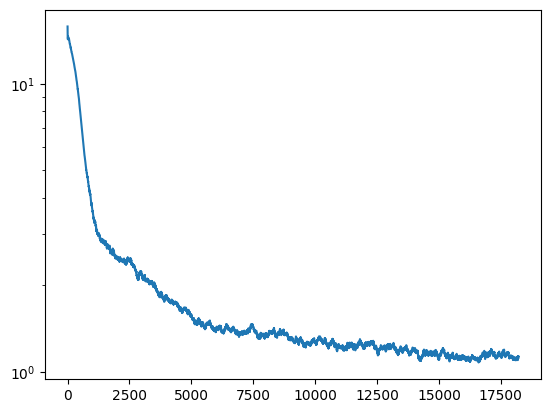

In [86]:
import matplotlib.pyplot as plt
pd.Series(losses).ewm(100).mean().plot();
plt.yscale('log');

# Now update the whole model, with embeddings and transformer layers.

In [ ]:
# save_model_path = '/content/drive/MyDrive/ml_models/bxr/mbart-large-50-bxr-v11'

In [ ]:
# model = MBartForConditionalGeneration.from_pretrained(save_model_path)
# tokenizer = MBart50Tokenizer.from_pretrained(save_model_path)

In [87]:
model.cuda();

In [88]:
loss = None
optimizer.zero_grad(set_to_none=True)
optimizer = None
cleanup()

In [89]:
for p in model.parameters():
    p.requires_grad = True

In [90]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-6,
    clip_threshold=1.0
)

In [91]:
batch_size = 8
report_steps = 500 
epochs = 10
losses = []


Optimizing all parameters takes x2 longer than just embeddings: about 1h per epoch.

In [92]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in trange(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))

EPOCH 0


  0%|          | 0/4554 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


step 0 loss 0.9538692235946655
step 500 loss 1.0387907318472862
step 1000 loss 1.0486903620958328
step 1500 loss 1.0414791787862778
step 2000 loss 1.0313097581267356
step 2500 loss 1.019704513221979
step 3000 loss 1.0041165587007999
step 3500 loss 1.013749116420746
step 4000 loss 1.0145788292884828
step 4500 loss 0.9992561968266964
EPOCH 1


  0%|          | 0/4554 [00:00<?, ?it/s]

step 0 loss 0.9842112250626087
step 500 loss 1.0104942086935043
step 1000 loss 0.9697150909304619
step 1500 loss 0.9859778600633144
step 2000 loss 0.9427432830929756
step 2500 loss 0.9633601409196854
step 3000 loss 0.9735920842289925
step 3500 loss 0.9937979790568352
step 4000 loss 0.9692025517225266
step 4500 loss 0.9518478450477124
EPOCH 2


  0%|          | 0/4554 [00:00<?, ?it/s]

step 0 loss 0.9542072132527828
step 500 loss 0.9320243346691132
step 1000 loss 0.9261045728921891
step 1500 loss 0.9513380925953389
step 2000 loss 0.9507859521210194
step 2500 loss 0.9283210136592388
step 3000 loss 0.9406496258974075
step 3500 loss 0.9362165288180113
step 4000 loss 0.943440494209528
step 4500 loss 0.9400227806270123


KeyboardInterrupt: ignored

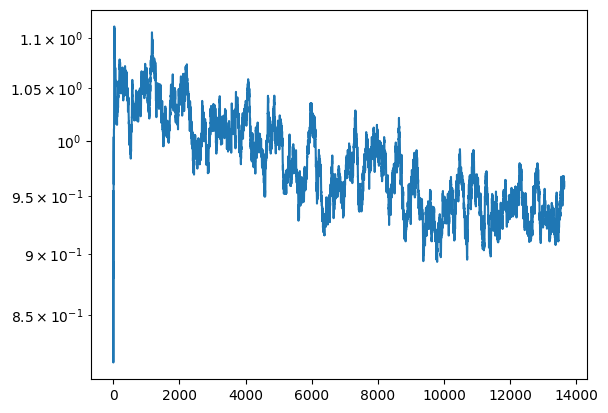

In [93]:
pd.Series(losses).ewm(100).mean().plot();
plt.yscale('log');

In [ ]:
# save_model_path = '/content/drive/MyDrive/ml_models/bxr/mbart-large-50-bxr-v12'

In [ ]:
# model.save_pretrained(save_model_path)
# tokenizer.save_pretrained(save_model_path)

In [94]:
model.eval();

In [95]:
bxr, ru = random.choice(all_pairs)
bxr, ru

('нилсайлгаха', 'расплющивать, разминать')

In [96]:
def translate(text, src='bxr_XX', trg='ru_RU', max_length=200, num_beams=5, repetition_penalty=5.0, **kwargs):
    tokenizer.src_lang = src
    encoded = tokenizer(text, return_tensors="pt")
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[trg], 
        max_length=max_length, 
        num_beams=num_beams,
        repetition_penalty=repetition_penalty,
        # early_stopping=True,
    )
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]

translate(bxr)

'сжимать, щёлкать'

In [97]:
loss = None
optimizer.zero_grad(set_to_none=True)
optimizer = None
cleanup()     

In [98]:
import os
os.makedirs("mbart-large-50-bxr-v12")
model.save_pretrained("mbart-large-50-bxr-v12")

In [99]:
tokenizer.save_pretrained('mbart-large-50-bxr-v12')

('mbart-large-50-bxr-v12/tokenizer_config.json',
 'mbart-large-50-bxr-v12/special_tokens_map.json',
 'mbart-large-50-bxr-v12/sentencepiece.bpe.model',
 'mbart-large-50-bxr-v12/added_tokens.json')

# Evaluate

In [100]:
with open('test.json', 'r') as f:
    test = json.load(f)

In [102]:
test[0]

['Таанад өөhэдөө ехэл сэсэн ухаантай, тиин тэнэг үбэштэй зондо ехэл тэсэбэритэй байдаг ха юмта!',
 'Ибо вы, люди разумные, охотно терпите неразумных:']

In [103]:
target = [ru for bxr, ru in test]

In [116]:
translated = [translate(bxr) for bxr, ru in tqdm(test)]

  0%|          | 0/1823 [00:00<?, ?it/s]

In [117]:
from sacrebleu import BLEU, CHRF
chrf = CHRF()
bleu = BLEU()

In [118]:
print('chrF: ', chrf.corpus_score(translated, target).score,
      'BLEU: ', bleu.corpus_score(translated, target).score)

chrF:  7.042253521126761 BLEU:  1.1158121339543965


In [125]:
for i in range(len(test)):
  if i%50==0:
        print(test[i][0])
        print('эталон: ', test[i][1])
        print('перевод: ', translated[i])
        print()

Таанад өөhэдөө ехэл сэсэн ухаантай, тиин тэнэг үбэштэй зондо ехэл тэсэбэритэй байдаг ха юмта!
эталон:  Ибо вы, люди разумные, охотно терпите неразумных:
перевод:  Вы же мудрые, но терпите сумасшедших.

Тиихэдэнь hохор хүн: «Давидай үри hадаhан Иисус, намайе үршөөжэ хайрлыш!» – гэжэ хашхарба. 
эталон:  Тогда он закричал: Иисус, Сын Давидов! помилуй меня.
перевод:  И закричал слепой: помилуй меня Иисус, Сын Давидов.

Мүнөө ажамидаржа байhан хүнүүдэй бултанайнь үхэжэ үрдеэгүй байхада минии таанадта хэлэhэн бүхэн тохёолдохо гэжэ таанадта баталан хэлэнэб.
эталон:  Истинно говорю вам: не прейдет род сей, как все сие будет;
перевод:  Истинно говорю вам: все, что Я сказал вам, придет ко всем нынешним.

Би тэдэндэ мүнхэ наhа үгэнэб, тэдэ хэзээшье хосорхогүй, тэдэниие намhаа хэншье буляажа абахагүй.
эталон:  И Я даю им жизнь вечную, и не погибнут вовек; и никто не похитит их из руки Моей.
перевод:  Я дам им вечную жизнь; они не погибнут, и никто их не защитит от Меня.

Тиигэжэл таанадые магтаhан

In [130]:
with open('bur_all.txt', 'r') as f:
    all_sentences = f.readlines()
print(len(all_sentences))
random.seed(1)
random.shuffle(all_sentences)

219597


In [131]:
def translate_batch(texts, src='bxr_XX', trg='ru_RU', max_length='auto', num_beams=5, repetition_penalty=5.0, **kwargs):
    tokenizer.src_lang = src
    encoded = tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt")
    if max_length == 'auto':
        max_length = int(10 + encoded.input_ids.shape[1] * 1.5)
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[trg], 
        max_length=max_length, 
        num_beams=num_beams,
        repetition_penalty=repetition_penalty,
        # early_stopping=True,
    )
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

In [132]:
translate_batch(all_sentences[:4])

['(Л. Лисин, 1974, No 2). БОрсОлхо — труп нарываться над облаками и сушиться в тень по земле (вялить мясо).',
 'Он покупает их в магазине, растирает макитами и вертит на них кукурузы.',
 'Старик с радостью посмотрел на Него, покаяясь в маме.',
 'В студенческий час я пошел за ним. — Ча-хү-хү!']

In [133]:
batch_size = 16
all_translated = []

In [134]:
cleanup()

for i in trange(0, len(all_sentences), batch_size):
    batch = all_sentences[i: i + batch_size]
    if all_translated[i: i + batch_size]:
        continue
    try:
        all_translated.extend(translate_batch(batch))
    except RuntimeError:
        print('error at', i)
        cleanup()
        bb = []
        for b in batch:
            try:
                bb.append(translate_batch([b])[0])
            except RuntimeError:
                print('mega error!')
                bb.append(b)
                cleanup()
        all_translated.extend(bb)

    if i and (i // batch_size) % 100 == 0:
        with open('back_translated.json', 'w') as f:
            json.dump({'original': all_sentences, 'translated': all_translated}, f, ensure_ascii=False, indent=2)
        print(i, 'saving...')

  0%|          | 0/13725 [00:00<?, ?it/s]

1600 saving...
3200 saving...
4800 saving...
6400 saving...
8000 saving...
9600 saving...
11200 saving...


KeyboardInterrupt: ignored

In [ ]:
with open('back_translated.json', 'w') as f:
    json.dump({'original': all_sentences, 'translated': all_translated}, f, ensure_ascii=False, indent=2)

In [135]:
for i in range(100):
  print(all_translated[i])
  print(all_sentences[i])
  print()

(Л. Лисин, 1974, No 2). БОрсОлхо — труп нарываться над облаками и сушиться в тень по земле (вялить мясо).
(Л. Линховоин, 1974, № 2).БОрсОлХО —  мяха зурагар наринуудаар зүhэжэ, hүүдэр газарта хатааха (вялить мясо).


Он покупает их в магазине, растирает макитами и вертит на них кукурузы.
Нагаса тэрэ таряалангай газарта арбай тарижа, арбайе арьбижуулжа, ехэ болгоhондо, тэрэ арбай та-ряагаар ехэ мяха худалдажа абаад, сагаан арбайгаар гурил хэжэ, хара арбайгаар дараса болгон шанаба.


Старик с радостью посмотрел на Него, покаяясь в маме.
Степан миhэд гээд Этигэлмаае энэрхыгээр харана.


В студенческий час я пошел за ним. — Ча-хү-хү!
Городой үүлэн нюдэтэй басагантай бурят хүн хэзээшье нэгэдэхэгүй гэжэ бодоошье hаа Ошор тэрэнэй гарыень табинагүй.УХоёрдохи дабхарта буугаад орхихолоорнь тэдэнэй урдаhаань Бамбаадиг ябажа ябаба.—Хү-хү-хү!


Подъехав с места, он поднялся на гору и узнав, что не в силах выскочить из скалы.
Шулуунуудай хоорондуур годирон, доошоо ороhон хүндын oёophoo булган өөдөө,